# Model A: Support Vector Machine with features extracted using ViT

This notebook is focused on training a **traditional machine learning model** with features extracted with a vision transformer (ViT) to solve the given image classification problem of identifying potato leaf diseases.

Specifically, this notebook uses the model from https://huggingface.co/google/vit-base-patch16-224. This is a vision transformer model that was trained on 14 million images with nearly 22k classes at a resolution of 224x224, and fune-tuned on a dataset of 1 million images with 1000 classes at the same resolution.

**Note that this vision transformer model is not trained in this notebook**, rather it is being utilized *in inference mode* as a method for extracting features from an image. Using the features obtained from this, a traditional supervised machine learning model, in the form of a Support Vector Machine (SVM), is trained to be able to classify potato diseases. There are 6 main classes in the dataset:
- Healthy
- Bacteria
- Virus
- Pest
- Fungi
- Phytopthora

Through this method, the model is able to obtain an **accuracy and f1-score of above 80%**.

# Training

## Install Dependencies

This section installs the needed dependencies to run this application in Google Colab. Note that, outside of Google Colab, these dependencies should be installed using the `requirements.txt` file instead.

In [1]:
# Only run in Google Colab
# !pip install transformers torch torchvision datasets==3.5.1 joblib tqdm

## Mount Drive
This section mounts the drive folder containing the project files to the notebook. Note that cells from this section should not be run if it is being run locally.

In [2]:
# Only run in Google Colab
# from google.colab import drive
# from google.colab import userdata

# drive.mount('/content/drive', force_remount=True)

## Setup Code
This section is primarily focused on setting up the necessary imports, variables, and functions for training the model.

### Setup Imports
The cells below imports all the libraries necessary to train the model.

In [ ]:
import os
import cv2
import numpy as np

from transformers import ViTModel, ViTFeatureExtractor

import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor
)
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Define constants
The cell below defines some notable constants used for training the model. This includes the size of test set, the seed used for generating random data, and the input and output directories.

In [4]:
# For Google Colab
# SHARED_DRIVE_NAME = "CS180 when the ooga is booga"
# DATA_DIR = f'/content/drive/Shareddrives/{SHARED_DRIVE_NAME}/potato_train_resized/train/'
# OUTPUT_DIR = f'/content/drive/Shareddrives/{SHARED_DRIVE_NAME}/traditional'
# TEST_DIR = f'/content/drive/Shareddrives/{SHARED_DRIVE_NAME}/potato_test/'
# SHARED_DIR = f'/content/drive/Shareddrives/{SHARED_DRIVE_NAME}/'

# For local
DATA_DIR = 'potato_train/train/'
OUTPUT_DIR = '.'
TEST_DIR = 'potato_test/'
SHARED_DIR = '.'

TEST_SIZE = 0.2
RANDOM_STATE = 80

### Setup ViT for image feature extraction



In [5]:
model_id = 'google/vit-base-patch16-224-in21k'
vit = ViTModel.from_pretrained(model_id)
# Disable training for ViT since this is only being used for feature extraction
vit.eval()

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

/home/ehren/programs/CS180/cs180-project/.venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Setup transforms for preprocessing

The cell below sets up the transforms responsible for preprocessing and applying data augmentations to the training and test images.

Note that no data augmentations are included in `training_transforms` besides `Resize`. Generally, this has produced a slightly better accuracy and f1-score.

In [6]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
size = (feature_extractor.size["height"], feature_extractor.size["width"])

# Data augmentations are *supposed to be* placed here
# Note, however, that no data augmentation is being done here outside of Resize
training_transforms = Compose([
    Resize(size),
    ToTensor(),
    normalize
])

inference_transforms = Compose([
    Resize(size),
    ToTensor(),
    normalize
])

### Setup feature extraction function

The cell below sets up the function used for extracting features from an image. Note that it expects an image in BGR (since this is the default format of openCV) and the transforms to be used as arguments.

In [7]:
def extract_features(img_original, transforms):
    # Note that OpenCV reads images with BGR by default
    # Thus, we need to convert it to RGB since it may cause issues otherwise
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # Get numpy array of image
    img = Image.fromarray(img_rgb)

    # Apply data augmentation and preprocessing transforms
    # `unsqueeze(0)` prepends the batch size of `1`
    # Technically, batching all the images would be faster
    # but its a bit awkward to implement
    img_tensor = transforms(img).unsqueeze(0)

    # Disable gradient calculation, use inference mode
    # The goal isn't to train, but to extract features
    with torch.no_grad():
        # Pass image through the pretrained vision transformer, get outputs
        outputs = vit(img_tensor)

        # Extracts features by getting the [CLS] token
        # This is more or less a summary feature vector for the image
        features = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    # Returns the feature vector
    return features

## Load Dataset

This section loads the dataset of images and their labels.

In [8]:
categories = ['Bacteria', 'Fungi', 'Healthy', 'Pest', 'Phytopthora', 'Virus']
num_labels = len(categories) # Number of unique labels

images, labels = [], []

for label, category in enumerate(categories):
    category_dir = os.path.join(DATA_DIR, category)
    for filename in os.listdir(category_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(category_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label)

images = np.array(images)
labels = np.array(labels)

## Train-test Split

This section splits the dataset to train and test datasets. It then preprocesses and extracts the features from the images in each set. It also runs `StandardScaler` to further normalize features.

In [9]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [11]:
X_train = [extract_features(img, training_transforms) for img in tqdm(X_train_raw, desc='Extracting Training Features')]
X_test = [extract_features(img, inference_transforms) for img in tqdm(X_test_raw,  desc='Extracting Test Features')]

Extracting Test Features: 100%|██████████| 542/542 [03:33<00:00,  2.54it/s]


In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Hyperparameter Tuning & Training

In this section, the `SVC` model is setup and put through hyperparameter tuning via `GridSearchCV` to find the best parameters and estimator.

In [13]:
# Note: linear and polynomial kernel will generally lose against rbf here
# rbf will have higher peaks given specific hyperparameters
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 'scale'],
    'class_weight': [None, 'balanced']
}

In [14]:
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, scoring='f1_weighted', cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END C=0.1, class_weight=None, gamma=0.0001;, score=0.338 total time=   2.1s
[CV 2/5] END C=0.1, class_weight=None, gamma=0.0001;, score=0.346 total time=   1.2s
[CV 3/5] END C=0.1, class_weight=None, gamma=0.0001;, score=0.325 total time=   2.0s
[CV 4/5] END C=0.1, class_weight=None, gamma=0.0001;, score=0.326 total time=   2.1s
[CV 5/5] END C=0.1, class_weight=None, gamma=0.0001;, score=0.356 total time=   2.1s
[CV 1/5] END C=0.1, class_weight=None, gamma=0.001;, score=0.550 total time=   1.7s
[CV 2/5] END C=0.1, class_weight=None, gamma=0.001;, score=0.570 total time=   1.8s
[CV 3/5] END C=0.1, class_weight=None, gamma=0.001;, score=0.574 total time=   1.9s
[CV 4/5] END C=0.1, class_weight=None, gamma=0.001;, score=0.556 total time=   2.0s
[CV 5/5] END C=0.1, class_weight=None, gamma=0.001;, score=0.582 total time=   1.8s
[CV 1/5] END C=0.1, class_weight=None, gamma=scale;, score=0.585 total time=   1.9s
[CV 2/5] 

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'gamma': [0.0001, 0.001, 'scale']},
             scoring='f1_weighted', verbose=3)

In [15]:
print(grid_search.best_params_)
print(grid_search.best_score_)

best_estimator = grid_search.best_estimator_

{'C': 5, 'class_weight': None, 'gamma': 0.001}
0.8309420986608675


Generate heatmaps to visualize and compare CV F1 scores with respect to Gamma and C.

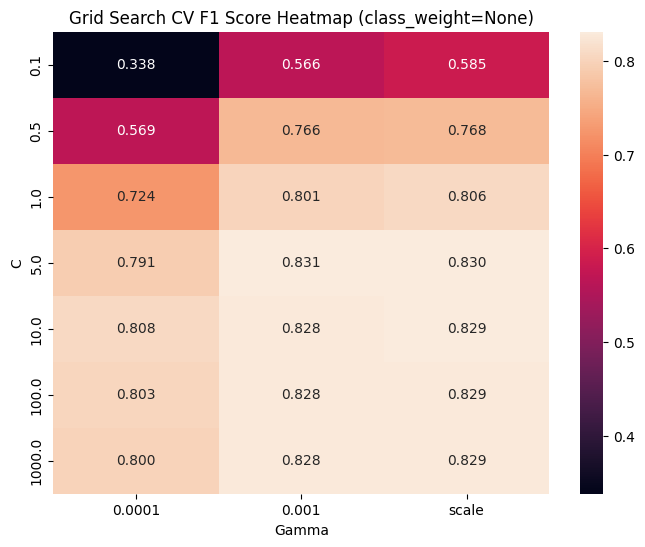

In [28]:
cv_results = pd.DataFrame(grid_search.cv_results_)
subset = cv_results[cv_results['param_class_weight'].isnull()]

pivot = subset.pivot_table(
    index='param_C',
    columns='param_gamma',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f")
plt.title("Grid Search CV F1 Score Heatmap (class_weight=None)")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()

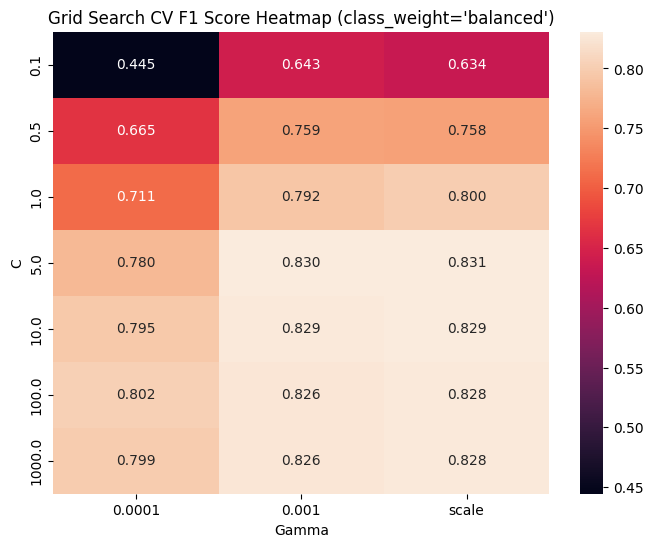

In [29]:
subset = cv_results[cv_results['param_class_weight'] == 'balanced']

pivot = subset.pivot_table(
    index='param_C',
    columns='param_gamma',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f")
plt.title("Grid Search CV F1 Score Heatmap (class_weight='balanced')")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()

## Model Evaluation

This section tests the model created and determines its performance.

In [30]:
y_pred = best_estimator.predict(X_test)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("Testing F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, target_names=categories))

Testing Accuracy: 0.8284132841328413
Testing F1 Score: 0.8281493385863974
              precision    recall  f1-score   support

    Bacteria       0.89      0.96      0.93       103
       Fungi       0.81      0.80      0.80       135
     Healthy       0.78      0.81      0.79        36
        Pest       0.77      0.78      0.77       110
 Phytopthora       0.96      0.77      0.86        62
       Virus       0.81      0.82      0.81        96

    accuracy                           0.83       542
   macro avg       0.84      0.82      0.83       542
weighted avg       0.83      0.83      0.83       542



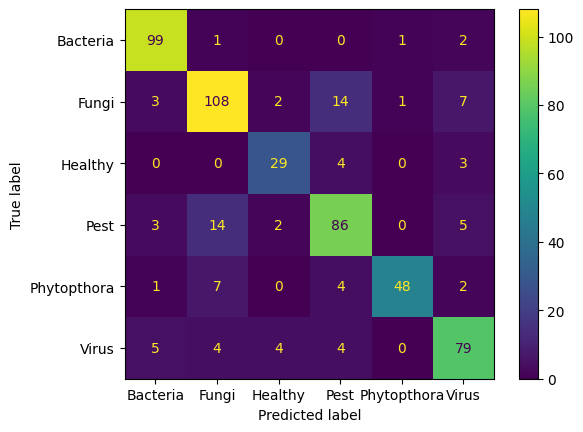

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=categories)

## Exporting Trained Model

This section exports the trained model and scaler using `joblib`. This is done so that these files can be used elsewhere or at a future point in time.

In [32]:
import joblib

In [33]:
joblib.dump(best_estimator, f'{OUTPUT_DIR}/traditional_model.joblib')
joblib.dump(scaler, f'{OUTPUT_DIR}/traditional_scaler.joblib')

['./traditional_scaler.joblib']

# Testing

## Labeling Test Samples

This section provides a prediction in the images provided at the `potato_test` folder and export a `.csv` file containing the predicted labels.

Save the test images to the `test_images` array variable

In [34]:
test_images = []
test_images_filename = []

for filename in os.listdir(TEST_DIR):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(TEST_DIR, filename)
        img = cv2.imread(img_path)
        if img is not None:
            test_images.append(img)
            test_images_filename.append(filename)

Extract the features of the images and save it in the `test_samples` variable

In [35]:
test_samples = [extract_features(img, inference_transforms) for img in tqdm(test_images,  desc='Extracting Test Features')]

Extracting Test Features: 100%|██████████| 301/301 [01:30<00:00,  3.31it/s]


Apply the scaler to standardize the test samples prior to passing it to the model.

In [36]:
test_samples = scaler.transform(test_samples)

Predict the labels of the test samples and save the predictions in the `test_pred` variable

In [37]:
test_pred = best_estimator.predict(test_samples)

Print the number of predicted labels in each category.

In [38]:
predicted_labels = [0, 0, 0, 0, 0, 0]

for prediction in test_pred:
    predicted_labels[prediction] += 1

for label, category in enumerate(categories):
    print(f'{category}: {predicted_labels[label]}')

Bacteria: 55
Fungi: 86
Healthy: 16
Pest: 58
Phytopthora: 33
Virus: 53


Save the predicted labels of the test samples in `traditional_predicted.csv`

In [39]:
import csv

with open(f'{OUTPUT_DIR}/traditional_predicted.csv', 'w', newline='') as f:
	fieldnames = ['image_filename', 'predicted_label']
	writer = csv.DictWriter(f, fieldnames=fieldnames)

	writer.writeheader()

	image_pred = []

	for i, filename in enumerate(test_images_filename):
		if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
			image_pred.append((filename, categories[test_pred[i]]))

	image_pred.sort()

	for filename, label in image_pred:
		if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
			writer.writerow({'image_filename': filename, 'predicted_label': label})
			print(filename, label)

0.jpeg Pest
1.jpeg Healthy
10.jpeg Healthy
100.jpeg Fungi
101.jpeg Fungi
102.jpeg Fungi
103.jpeg Fungi
104.jpeg Pest
105.jpeg Fungi
106.jpeg Fungi
107.jpeg Fungi
108.jpeg Fungi
109.jpeg Fungi
11.jpeg Healthy
110.jpeg Fungi
111.jpeg Fungi
112.jpeg Pest
113.jpeg Fungi
114.jpeg Fungi
115.jpeg Fungi
116.jpeg Virus
117.jpeg Pest
118.jpeg Fungi
119.jpeg Fungi
12.jpeg Healthy
120.jpeg Fungi
121.jpeg Fungi
122.jpeg Fungi
123.jpeg Fungi
124.jpeg Fungi
125.jpeg Fungi
126.jpeg Fungi
127.jpeg Fungi
128.jpeg Fungi
129.jpeg Fungi
13.jpeg Healthy
130.jpeg Fungi
131.jpeg Fungi
132.jpeg Fungi
133.jpeg Virus
134.jpeg Virus
135.jpeg Virus
136.jpeg Fungi
137.jpeg Fungi
138.jpeg Fungi
139.jpeg Fungi
14.jpeg Healthy
140.jpeg Fungi
141.jpeg Phytopthora
142.jpeg Fungi
143.jpeg Fungi
144.jpeg Pest
145.jpeg Fungi
146.jpeg Fungi
147.jpeg Fungi
148.jpeg Fungi
149.jpeg Fungi
15.jpeg Healthy
150.jpeg Fungi
151.jpeg Fungi
152.jpeg Fungi
153.jpeg Fungi
154.jpeg Fungi
155.jpeg Pest
156.jpeg Pest
157.jpeg Pest
158.jpeg